In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime
import pandas as pd
import numpy as np
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.regression.linear_model import OLS

In [2]:
table2_data_raw = pd.read_csv("data/merged_data.csv")
# only need the rows with the data, first 4 rows and last 1 row are not needed
table2_ff5 = pd.read_csv("data/FF5_monthly.csv")
table2_UMD = pd.read_csv("data/FF_Momentum_monthly.csv")
# Rename columns to ensure 'date' column is correctly named

table2_ff5.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
table2_UMD.columns = ['date', 'UMD']

table2_data_raw['date'] = pd.to_datetime(table2_data_raw['date'])
table2_ff5['date'] = pd.to_datetime(table2_ff5['date'], format='%Y%m')
table2_UMD['date'] = pd.to_datetime(table2_UMD['date'], format='%Y%m')


In [3]:
# Get the data original sample research, so first we need to get the data before 1963-07-01 to ensure we have the valid data for the whole period
start_date_original = '1963-07-01'
end_date = '2023-12-29' #20231230 and 20231231 are weekends, not in the data
print(f'Predictor number of start month: {len(table2_data_raw[table2_data_raw['date'] < start_date_original]['predictor'].unique())}') # check if the data aviablable for the whole period
factor_original_data = table2_data_raw[table2_data_raw['date'] < start_date_original]['predictor'].unique()
table2_data_original = table2_data_raw[table2_data_raw['predictor'].isin(factor_original_data)]
table2_data_original = table2_data_original[(table2_data_original['date'] >= start_date_original) & (table2_data_original['date'] <= end_date)]
print(f'Predictor number of end month: {len(table2_data_original[table2_data_original['date'] == end_date]['predictor'].unique())}') #check if the data aviablable for the whole period


# Get the data for original sample research, same data period
# modify the table2_data_original like table2_data above
table2_data_original['month'] = table2_data_original['date'].dt.month
table2_data_original['year'] = table2_data_original['date'].dt.year
table2_data_original['month_year'] = table2_data_original['date'].dt.to_period('M')
# sum the daily returns by month
table2_data_monthly_original = table2_data_original.groupby(['month_year', 'predictor'])[['port01','port02','port03','port04','port05','portLS']].sum().reset_index()
table2_data_monthly_original['date'] = table2_data_monthly_original['month_year'].dt.to_timestamp()
table2_data_monthly_original = table2_data_monthly_original.drop(['month_year'], axis=1)
table2_data_monthly_original = table2_data_monthly_original.sort_values(by=['predictor','date'])
table2_data_monthly_original = table2_data_monthly_original.reset_index(drop=True)
# put date in first column
cols = table2_data_monthly_original.columns.tolist()
cols = cols[-1:] + cols[:-1]
table2_data_monthly_original = table2_data_monthly_original[cols]
table2_data_monthly_original.set_index('date', inplace=True)
# divide 100
table2_data_monthly_original[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] = table2_data_monthly_original[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] / 100
table2_data_monthly_original['portLS2'] = (table2_data_monthly_original['port05'] + table2_data_monthly_original['port04'] - table2_data_monthly_original['port02'] - table2_data_monthly_original['port01'])/2
table2_data_monthly_original

Predictor number of start month: 50
Predictor number of end month: 50


,predictor,port01,port02,port03,port04,port05,portLS,portLS2
date,,,,,,,,
1963-07-01,Accruals,-0.022245,0.007165,-0.002217,0.003021,0.003446,0.025691,0.010773
1963-08-01,Accruals,0.056922,0.053736,0.059434,0.048730,0.047843,-0.009079,-0.007043
1963-09-01,Accruals,-0.010046,-0.014426,-0.025168,-0.002418,-0.008202,0.001844,0.006926
1963-10-01,Accruals,0.014035,0.020162,0.013247,0.027338,0.058784,0.044749,0.025962
1963-11-01,Accruals,-0.005624,-0.008867,-0.007389,0.016824,-0.020129,-0.014506,0.005593
...,...,...,...,...,...,...,...,...
2023-08-01,std_turn,-0.188815,-0.068048,-0.025704,-0.032045,-0.022582,0.166233,0.101118
2023-09-01,std_turn,-0.067067,-0.050836,-0.034021,-0.052222,-0.044330,0.022738,0.010676
2023-10-01,std_turn,-0.138222,-0.100143,-0.061419,-0.033710,-0.044634,0.093587,0.080010


In [4]:
# Update data from 1999-01-01 to 2023-12-29, 
start_date_update = '1999-01-01'
end_date = '2023-12-29'
table2_data = table2_data_raw[(table2_data_raw['date'] >= start_date_update) & (table2_data_raw['date'] <= end_date)].copy()
# Get the remaining factors belonging to the time frame
unique_predictors_update = table2_data['predictor'].unique()
print(f'The list of predictors is: \n{unique_predictors_update}')
print(f'Total predictor number is: {len(unique_predictors_update)}')

The list of predictors is: 
['Accruals' 'AnalystValue' 'AssetGrowth' 'BM' 'BPEBM' 'Beta'
 'BetaLiquidityPS' 'BookLeverage' 'CBOperProf' 'CF' 'CPVolSpread'
 'ChAssetTurnover' 'ChNWC' 'CompEquIss' 'CompositeDebtIssuance'
 'Coskewness' 'CustomerMomentum' 'DolVol' 'EBM' 'EP' 'EarningsSurprise'
 'FirmAge' 'Frontier' 'GP' 'Herf' 'High52' 'IdioVol3F' 'Illiquidity'
 'IntMom' 'InvGrowth' 'LRreversal' 'MaxRet' 'Mom12m' 'Mom6m' 'Mom6mJunk'
 'MomOffSeason' 'MomOffSeason06YrPlus' 'MomOffSeason11YrPlus'
 'MomOffSeason16YrPlus' 'MomSeason' 'MomSeason06YrPlus'
 'MomSeason11YrPlus' 'MomSeason16YrPlus' 'MomSeasonShort' 'NOA' 'OperProf'
 'PS' 'RDAbility' 'RIVolSpread' 'ResidualMomentum' 'RoE' 'SP' 'STreversal'
 'ShareIss1Y' 'ShareIss5Y' 'Size' 'VolMkt' 'VolSD' 'XFIN' 'cfp' 'roaq'
 'std_turn']
Total predictor number is: 62


In [5]:
# first get the monthly returns for each stock, sum of the daily returns by month
table2_data['month'] = table2_data['date'].dt.month
table2_data['year'] = table2_data['date'].dt.year
table2_data['month_year'] = table2_data['date'].dt.to_period('M')
# sum the daily returns by month
table2_data_monthly = table2_data.groupby(['month_year', 'predictor'])[['port01','port02','port03','port04','port05','portLS']].sum().reset_index()
table2_data_monthly['date'] = table2_data_monthly['month_year'].dt.to_timestamp()
table2_data_monthly = table2_data_monthly.drop(['month_year'], axis=1)
table2_data_monthly = table2_data_monthly.sort_values(by=['predictor','date'])
table2_data_monthly = table2_data_monthly.reset_index(drop=True)
# put date in first column
cols = table2_data_monthly.columns.tolist()
cols = cols[-1:] + cols[:-1]
table2_data_monthly = table2_data_monthly[cols]
table2_data_monthly.set_index('date', inplace=True)
# divide 100
table2_data_monthly[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] = table2_data_monthly[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] / 100
table2_data_monthly['portLS2'] = (table2_data_monthly['port05'] + table2_data_monthly['port04'] - table2_data_monthly['port02'] - table2_data_monthly['port01'])/2
table2_data_monthly

,predictor,port01,port02,port03,port04,port05,portLS,portLS2
date,,,,,,,,
1999-01-01,Accruals,0.079906,-0.001093,0.026478,0.005808,0.081018,0.001112,0.004006
1999-02-01,Accruals,-0.049856,-0.016759,-0.012612,-0.026950,-0.072324,-0.022469,-0.016330
1999-03-01,Accruals,0.043410,0.037410,0.034296,0.036752,0.041223,-0.002187,-0.001422
1999-04-01,Accruals,0.067969,0.022862,0.022378,0.077499,0.028817,-0.039152,0.007742
1999-05-01,Accruals,-0.029193,-0.018245,-0.017828,0.001053,-0.024211,0.004982,0.012140
...,...,...,...,...,...,...,...,...
2023-08-01,std_turn,-0.188815,-0.068048,-0.025704,-0.032045,-0.022582,0.166233,0.101118
2023-09-01,std_turn,-0.067067,-0.050836,-0.034021,-0.052222,-0.044330,0.022738,0.010676
2023-10-01,std_turn,-0.138222,-0.100143,-0.061419,-0.033710,-0.044634,0.093587,0.080010


## Table 2
### Panel A

In [6]:
# Define Factor Momentum Strategy Function
def factor_momentum_strategy(returns, L, H, n_long_short):

    strategy_returns = pd.Series(index=returns.index, dtype=float)
    N = returns.shape[1]  
    for t in range(L, len(returns)):
        # Formation period: t-L to t-1 (using full data history up to t)
        past_returns = returns.iloc[t-L:t].mean()  # Average return over last L months
        # Rank factors
        ranked_factors = past_returns.sort_values(ascending=False)
        # Select top and bottom n_long_short factors
        long_factors = ranked_factors.index[:n_long_short]
        short_factors = ranked_factors.index[-n_long_short:]
        
        # Holding period: t to t+H-1
        if H == 1:
            # For H=1, take the next month's return
            long_returns = returns.iloc[t][long_factors].mean()
            short_returns = returns.iloc[t][short_factors].mean()
            strategy_returns.iloc[t] = long_returns - short_returns
        else:
            holding_returns = []
            for h in range(H):
                if t - h >= L:  # to ensure the data have enough history L months
                    past_h = returns.iloc[t-h-L:t-h].mean()  # to calculate the average return over last L months
                    ranked_h = past_h.sort_values(ascending=False)
                    long_h = ranked_h.index[:n_long_short]
                    short_h = ranked_h.index[-n_long_short:]

                    if t + h < len(returns):  # ensure the data not out of range
                        future_h = returns.iloc[t+h][long_h].mean() - returns.iloc[t+h][short_h].mean()
                        holding_returns.append(future_h)
            if len(holding_returns) == H: # ensure the each month has H returns from the strategies
                strategy_returns.iloc[t] = np.mean(holding_returns) if holding_returns else np.nan
    
    return strategy_returns

In [7]:
# get the data for table2 Panel A
# Pivot the data to have each predictor's portLS as a column
table2_LS1 = table2_data_monthly.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2 = table2_data_monthly.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Pivot the data to have each predictor's portLS as a column for the original data
table2_LS1_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Compute Strategies
N = len(table2_data_monthly['predictor'].unique())  # Fixed number of factors
n = max(round(3/20 * N), 1)  # n = 9

# Long TOP 20% and Short BOTTOM 20% of factors for the update data
# L=1, H=1
LS1_1_1 = factor_momentum_strategy(table2_LS1, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6 = factor_momentum_strategy(table2_LS1, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors
# L=1, H=1
LS2_1_1 = factor_momentum_strategy(table2_LS2, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6 = factor_momentum_strategy(table2_LS2, L=6, H=6, n_long_short=n)

# Long TOP 20% and Short BOTTOM 20% of factors for the original data
# L=1, H=1
LS1_1_1_original = factor_momentum_strategy(table2_LS1_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6_original = factor_momentum_strategy(table2_LS1_original, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors for the original data
# L=1, H=1
LS2_1_1_original = factor_momentum_strategy(table2_LS2_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6_original = factor_momentum_strategy(table2_LS2_original, L=6, H=6, n_long_short=n)


In [8]:
def compute_statistics(returns, H):
    returns = returns.dropna()
    
    # Annualized return: Monthly mean * 12
    ann_return = returns.mean() * 12 * 100  # In percentage
    
    # Annualized standard deviation: Monthly std * sqrt(12)
    ann_std = returns.std() * np.sqrt(12) * 100  # In percentage
    
    # Compute Newey-West t-value
    # Fit a constant-only model (equivalent to computing the mean)
    X = np.ones(len(returns))  # Constant term for mean
    model = OLS(returns, X).fit()
    
    # Compute Newey-West standard error
    # Choose lags based on H (e.g., H for overlapping returns, or a rule like floor(0.75 * T^(1/3)))
    lags = H # lag 4 month if H=1
    nw_cov = cov_hac(model, nlags=lags)  # Newey-West covariance matrix
    nw_se = np.sqrt(nw_cov[0, 0])  # Standard error of the mean (constant term)
    
    # Newey-West t-value: mean / Newey-West standard error
    t_value = returns.mean() / nw_se
    
    return ann_return, ann_std, t_value

In [9]:
# Define the filter_returns function
def filter_returns(returns, start_date, end_date):
    return returns[(returns.index >= start_date) & (returns.index <= end_date)].dropna()

# Define strategies with updated and original data
strategies = {
    'LS1_1_1': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1},
    'LS1_6_6': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6},
    'LS2_1_1': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1},
    'LS2_6_6': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6},
    'LS1_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1_original},
    'LS1_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6_original},
    'LS2_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1_original},
    'LS2_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6_original}
}

# Define time periods, including the original period
time_periods = [
    ('all', datetime(2000, 1, 1), datetime(2023, 12, 31)),
    ('sample', datetime(2000, 1, 1), datetime(2016, 12, 31)),
    ('post', datetime(2017, 1, 1), datetime(2023, 12, 31)),
    ('original', datetime(1963, 7, 1), datetime(2016, 12, 31))
]

# Compute statistics for each strategy and period
results = []
for period_name, start_date, end_date in time_periods:
    for strategy_name, params in strategies.items():
        L, H, factor, data = params['L'], params['H'], params['Factor'], params['data']
        # Skip if the period is not applicable to the data
        if period_name == 'original' and 'original' not in strategy_name:
            continue
        if period_name in ['all', 'sample', 'post'] and 'original' in strategy_name:
            continue
        
        filtered_returns = filter_returns(data, start_date, end_date)
        ann_return, ann_std, t_value = compute_statistics(filtered_returns, H)
        results.append({
            'Factor': factor,
            'Formation period': L,
            'Holding period': H,
            'Period': period_name,
            'Annualized return': ann_return,
            'Standard deviation': ann_std,
            't-value': t_value
        })

# Create DataFrame and format the results
table2_pa_results = pd.DataFrame(results)
table2_pa_results['Period'] = pd.Categorical(table2_pa_results['Period'], categories=['all', 'sample', 'post', 'original'], ordered=True)
table2_pa_results = table2_pa_results.sort_values(by=['Period', 'Factor', 'Formation period', 'Holding period'])
table2_pa_results = table2_pa_results[['Period', 'Factor', 'Formation period', 'Holding period', 'Annualized return', 'Standard deviation', 't-value']]
table2_pa_results = table2_pa_results.round(2)

# Print the results in the desired format
print("Panel A: Annualized percent returns and standard deviations")
table2_pa_results

Panel A: Annualized percent returns and standard deviations


,Period,Factor,Formation period,Holding period,Annualized return,Standard deviation,t-value
0,all,LS1,1,1,5.64,25.44,1.17
1,all,LS1,6,6,0.76,8.02,0.27
2,all,LS2,1,1,6.06,19.35,1.62
3,all,LS2,6,6,0.91,6.58,0.39
4,sample,LS1,1,1,5.25,27.50,0.86
5,sample,LS1,6,6,0.43,8.58,0.12
6,sample,LS2,1,1,5.73,20.75,1.22
7,sample,LS2,6,6,0.44,7.03,0.15
8,post,LS1,1,1,6.61,19.69,0.88
9,post,LS1,6,6,1.60,6.40,0.47


### Panel B

In [10]:
# Panel B
start_date = '2000-01-01'
end_date = '2023-12-31'
# combine the FF5 and UMD data
table2_ff5 = table2_ff5[(table2_ff5['date'] >= start_date) & (table2_ff5['date'] <= end_date)]
table2_UMD = table2_UMD[(table2_UMD['date'] >= start_date) & (table2_UMD['date'] <= end_date)]
table2_FF5_UMD = pd.merge(table2_ff5, table2_UMD, on='date', how='inner')
table2_FF5_UMD.set_index('date', inplace=True)
table2_FF5_UMD = table2_FF5_UMD[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','UMD']] / 100

# combine the LS data
table2_LS_11 = pd.concat([LS1_1_1, LS2_1_1], axis=1)
table2_LS_11.columns = ['LS1_1_1', 'LS2_1_1']
table2_LS_66 = pd.concat([LS1_6_6, LS2_6_6], axis=1)
table2_LS_66.columns = ['LS1_6_6', 'LS2_6_6']
table2_LS_11.dropna(inplace=True)
table2_LS_66.dropna(inplace=True)
# merge the LS data with FF5 and UMD data
table2_FF5_UMD_LS_11 = pd.merge(table2_FF5_UMD, table2_LS_11, left_index=True, right_index=True, how='inner')
table2_FF5_UMD_LS_66 = pd.merge(table2_FF5_UMD, table2_LS_66, left_index=True, right_index=True, how='inner')

In [11]:
# Define the dependent variables (strategy returns from Panel A)
dependent_vars = {
   'LS1_1_1': table2_FF5_UMD_LS_11 ['LS1_1_1'],  #  L=1, H=1, Long top 20%, short bottom 20%
   'LS1_6_6': table2_FF5_UMD_LS_66['LS1_6_6'],  # L=6, H=6, Long top 20%, short bottom 20%
   'LS2_1_1': table2_FF5_UMD_LS_11 ['LS2_1_1'],  #  L=1, H=1, Long top 40%, short bottom 40%
   'LS2_6_6': table2_FF5_UMD_LS_66['LS2_6_6']   #  L=6, H=6, Long top 40%, short bottom 40%
}

# Define the independent variables (factors, excluding RF as per factor model convention)
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Function to run spanning regression
def run_spanning_regression(dep_var, ind_vars, label):
    X = sm.add_constant(ind_vars)
    model = sm.OLS(dep_var, X).fit()  
    print(f"\nRegression Results for {label}:")
    print(model.summary())
    return model.params['const'], model.tvalues['const']

In [12]:
# Run regressions for each strategy ( FF5 + UMD only)
results = {}

# 1. Long-Short 20% (L=1, H=1)
ind_vars_1 = table2_FF5_UMD_LS_11[factors]
alpha_1, t_stat_1 = run_spanning_regression(dependent_vars['LS1_1_1'], ind_vars_1, 'Long-Short 20%, L=1, H=1')
results['LS1_1_1'] = (alpha_1, t_stat_1)  # Convert to percent


Regression Results for Long-Short 20%, L=1, H=1:
                            OLS Regression Results                            
Dep. Variable:                LS1_1_1   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     8.066
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           4.76e-08
Time:                        00:05:49   Log-Likelihood:                 366.77
No. Observations:                 288   AIC:                            -719.5
Df Residuals:                     281   BIC:                            -693.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [13]:
# 2. Long-Short 20% (L=6, H=6)
ind_vars_2 = table2_FF5_UMD_LS_66[factors]
alpha_2, t_stat_2 = run_spanning_regression(dependent_vars['LS1_6_6'], ind_vars_2, 'Long-Short 20%, L=6, H=6')
results['LS1_6_6'] = (alpha_2, t_stat_2)


Regression Results for Long-Short 20%, L=6, H=6:
                            OLS Regression Results                            
Dep. Variable:                LS1_6_6   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.253
Date:                Sat, 15 Mar 2025   Prob (F-statistic):            0.00417
Time:                        00:05:50   Log-Likelihood:                 674.37
No. Observations:                 283   AIC:                            -1335.
Df Residuals:                     276   BIC:                            -1309.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [14]:
# 3. Long-Short 40% (L=1, H=1)
ind_vars_3 = table2_FF5_UMD_LS_11[factors]
alpha_3, t_stat_3 = run_spanning_regression(dependent_vars['LS2_1_1'], ind_vars_3, 'Long-Short 40%, L=1, H=1')
results['LS2_1_1'] = (alpha_3, t_stat_3)


Regression Results for Long-Short 40%, L=1, H=1:
                            OLS Regression Results                            
Dep. Variable:                LS2_1_1   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     9.303
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           2.62e-09
Time:                        00:05:50   Log-Likelihood:                 448.85
No. Observations:                 288   AIC:                            -883.7
Df Residuals:                     281   BIC:                            -858.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [15]:
# 4. Long-Short 40% (L=6, H=6)
ind_vars_4 = table2_FF5_UMD_LS_66[factors]
alpha_4, t_stat_4 = run_spanning_regression(dependent_vars['LS2_6_6'], ind_vars_4, 'Long-Short 40%, L=6, H=6')
results['LS2_6_6'] = (alpha_4, t_stat_4)


Regression Results for Long-Short 40%, L=6, H=6:
                            OLS Regression Results                            
Dep. Variable:                LS2_6_6   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.884
Date:                Sat, 15 Mar 2025   Prob (F-statistic):            0.00964
Time:                        00:05:50   Log-Likelihood:                 729.27
No. Observations:                 283   AIC:                            -1445.
Df Residuals:                     276   BIC:                            -1419.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

## Figure 4: P&L curve

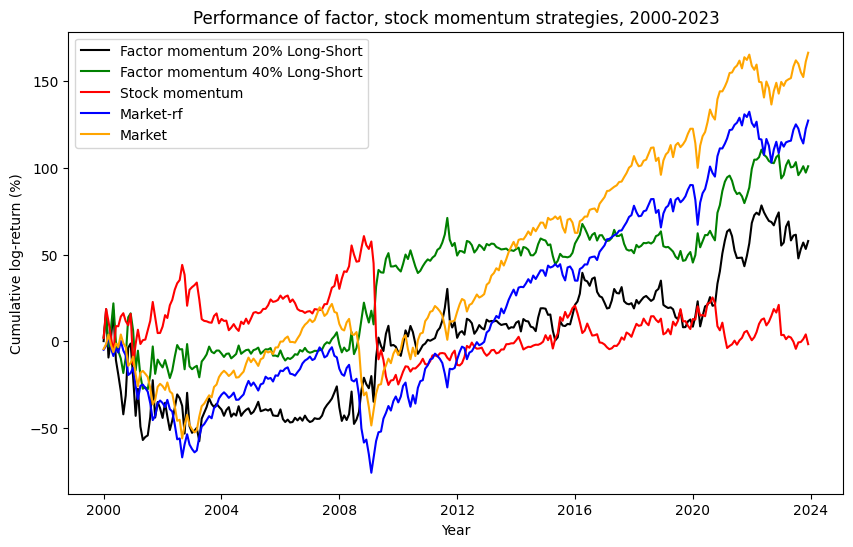

In [16]:
# the data period is from 2000-2023, use the 62 factors data
# the factor momentum is the strategy return we got in Table 1 Panel A, with L=1, H=1
# the stock momentum is the UMD factor in FF5_UMD data
# the market factor is the Mkt-RF in FF5_UMD data
# the risk-free rate is the RF in FF5_UMD data
# the market is the sum of Mkt-RF and RF

figure4_factor_mom = pd.concat([LS1_1_1, LS2_1_1], axis=1)
figure4_factor_mom.columns = ['LS1_1_1', 'LS2_1_1']
figure4_factor_mom.dropna(inplace=True)
figure4_stock_mom = table2_FF5_UMD['UMD'].copy()
figure4_stock_mom.columns = ['UMD']
MKT_RET = table2_FF5_UMD[['Mkt-RF', 'RF']].copy()
MKT_RET.columns = ['Mkt-RF', 'RF']
MKT_RET['MTK'] = MKT_RET['RF'] + MKT_RET['Mkt-RF'] 
MKT_RET.drop(['RF'], axis=1, inplace=True)
PL_cruve = pd.concat([figure4_factor_mom, figure4_stock_mom, MKT_RET], axis=1)
PL_cruve.columns = ['LS1_1_1', 'LS2_1_1', 'UMD','Mkt-RF', 'MKT']
PL_cruve.dropna(inplace=True)

cumulative_log_returns = np.log(PL_cruve+1).cumsum() * 100
plt.figure(figsize=(10, 6))
plt.plot(cumulative_log_returns['LS1_1_1'], color='black', label='Factor momentum 20% Long-Short')
plt.plot(cumulative_log_returns['LS2_1_1'], color='green', label='Factor momentum 40% Long-Short')
plt.plot(cumulative_log_returns['UMD'], color='red', label='Stock momentum')
plt.plot(cumulative_log_returns['Mkt-RF'], color='blue', label='Market-rf')
plt.plot(cumulative_log_returns['MKT'], color='orange', label='Market')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative log-return (%)")
plt.title("Performance of factor, stock momentum strategies, 2000-2023")
plt.show()

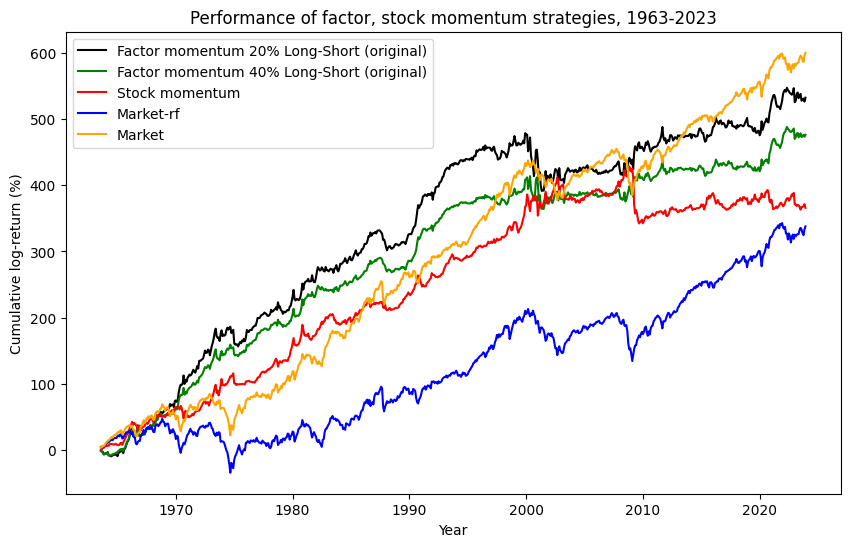

In [17]:
# the data period is from 1963-2023, use the 50 factors data, the original data
# the factor momentum is the strategy return we got in Table 1 Panel A, with L=1, H=1
# the stock momentum is the UMD factor in FF5_UMD data
# the market factor is the Mkt-RF in FF5_UMD data
# the risk-free rate is the RF in FF5_UMD data
# the market is the sum of Mkt-RF and RF

table2_ff5 = pd.read_csv("data/FF5_monthly.csv")
table2_UMD = pd.read_csv("data/FF_Momentum_monthly.csv")
table2_ff5.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
table2_UMD.columns = ['date', 'UMD']
table2_ff5['date'] = pd.to_datetime(table2_ff5['date'], format='%Y%m')
table2_UMD['date'] = pd.to_datetime(table2_UMD['date'], format='%Y%m')
table2_ff5.set_index('date', inplace=True)
table2_UMD.set_index('date', inplace=True)

table_test = pd.merge(table2_ff5, table2_UMD, on='date')
table_test = table_test[['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']]/ 100

# the original data from 1963 to 2023
figure4_factor_test = pd.concat([LS1_1_1_original,LS2_1_1_original], axis=1)
figure4_stock_test = table_test[['UMD','Mkt-RF', 'RF']].copy()
figure4_stock_test.columns = ['UMD', 'Mkt-RF', 'RF']
figure4_stock_test['MTK'] = figure4_stock_test['RF'] + figure4_stock_test['Mkt-RF']
figure4_stock_test.drop(['RF'], axis=1, inplace=True)
PL_cruve_test = pd.concat([figure4_factor_test,figure4_stock_test], axis=1)
PL_cruve_test.columns = ['LS1_1_1_original', 'LS2_1_1_original', 'UMD', 'Mkt-RF','MKT']
PL_cruve_test.dropna(inplace=True)
cumulative_log_returns = np.log(PL_cruve_test+1).cumsum() * 100
plt.figure(figsize=(10, 6))
plt.plot(cumulative_log_returns['LS1_1_1_original'], color='black', label='Factor momentum 20% Long-Short (original)')
plt.plot(cumulative_log_returns['LS2_1_1_original'], color='green', label='Factor momentum 40% Long-Short (original)')
plt.plot(cumulative_log_returns['UMD'], color='red', label='Stock momentum')
plt.plot(cumulative_log_returns['Mkt-RF'], color='blue', label='Market-rf')
plt.plot(cumulative_log_returns['MKT'], color='orange', label='Market')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative log-return (%)")
plt.title("Performance of factor, stock momentum strategies, 1963-2023")
plt.show()